# Synthetic Image Creation Using Keras with DCGAN.

* Deep Convolutional Generative Adversarial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libraries
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.11.0


In [3]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Uploading Data and Performing Pre-processing

**Dataset**: [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist)

In [4]:
#Download the Fashion MNIST dataset via keras. 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4422102/4422102 [==============================] - 0s 0us/step


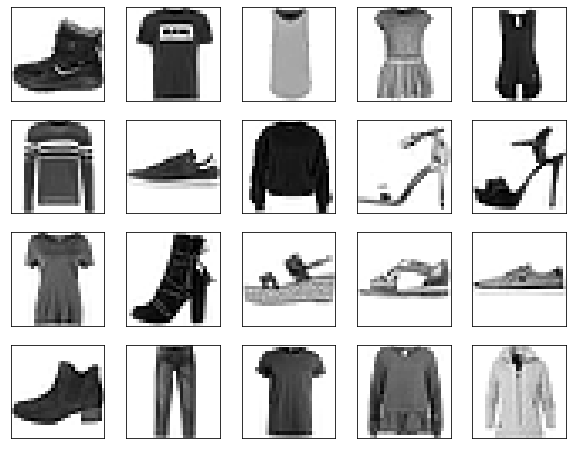

In [5]:
# Print 20 samples of 10x10 pixels from the dataset to the screen and see what it looks like.
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## Creation of Training Data and Groups

In [6]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements,
#then it generates random samples by replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
# Collectively combines consecutive elements of this dataset.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Creation of The Generative Network for DCGAN

* In GAN models, **SELU** and **TANH** are generally used as activation functions in the middle layers.
* In output layers, **SIGMOID** or **SOFTMAX** are preferred.
* DCGAN consists of two networks, Convolution and Deconvolution.Because the Generative and Discrimination networks are convolutional, they are called **Deep Convolutional Generative Adversarial Networks**.

In [7]:
# Convolutional neural network in the genarative layer
num_features = 100 # number of features

# It is started according to the number of features we give the input value.
# Used the Conv2DTranspose version.
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

* When modeling GAN, **Gaussian Distribution** is used instead of uniform distribution when choosing hidden space samples.
* This increases **Stochastic Durability**.
* Because GAN training results are in a dynamic balance, GANs are prone to stalemate in all directions.Randomness helps prevent this from happening during training.

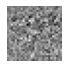

In [8]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
show(generated_images, 1)

## Creating the discriminator network for DCGAN
* The discriminator network takes an image as input, which can be synthetic or real, and guesses whether the image comes from the training dataset or is generated by the generative network.This part of the model consists of a familiar convolutional neural network and works like a classifier.There are two convolutional two layers of activation functions starting from the image and going through all the link layers.
* In this discriminator model, **LeakyReLU** or **ReLU** is preferred as the activation function.

In [9]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.4984443]], shape=(1, 1), dtype=float32)


##Compilation of DCGAN

In [11]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Visualizing training processes

In [12]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [13]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
           # Print the produced images to the screen and save them to the file.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [14]:
def generate_and_save_images(model, epoch, test_input):
  # 'Training' is set to False.
  # So all layers work in batchnorm mode.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(20):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training the DCGAN

In [15]:
# Resizing for education
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [16]:
#determination batch size and shuffle properties
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

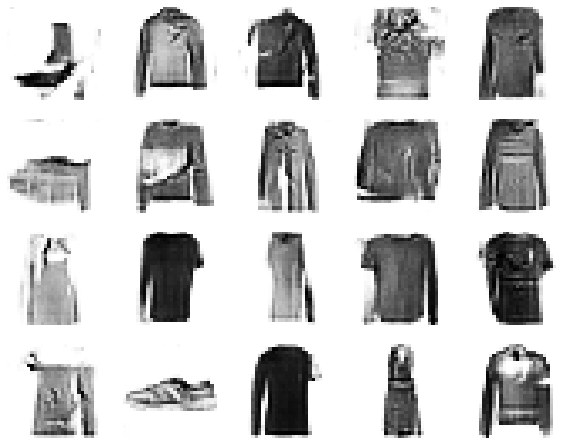

CPU times: user 10min 30s, sys: 22.8 s, total: 10min 53s
Wall time: 11min 2s


In [17]:
# The training gan model will be 10 epochs with the batch_size size and number of features determined for the defined dataset, 
# and the development of the model can be observed by changing the number of epochs.
%%time 
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## Creation of synthetic images with DCGAN

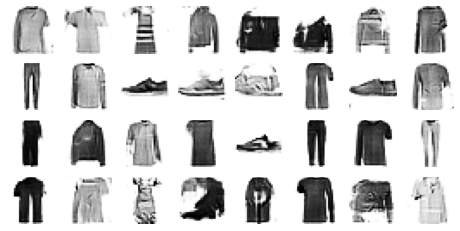

In [18]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

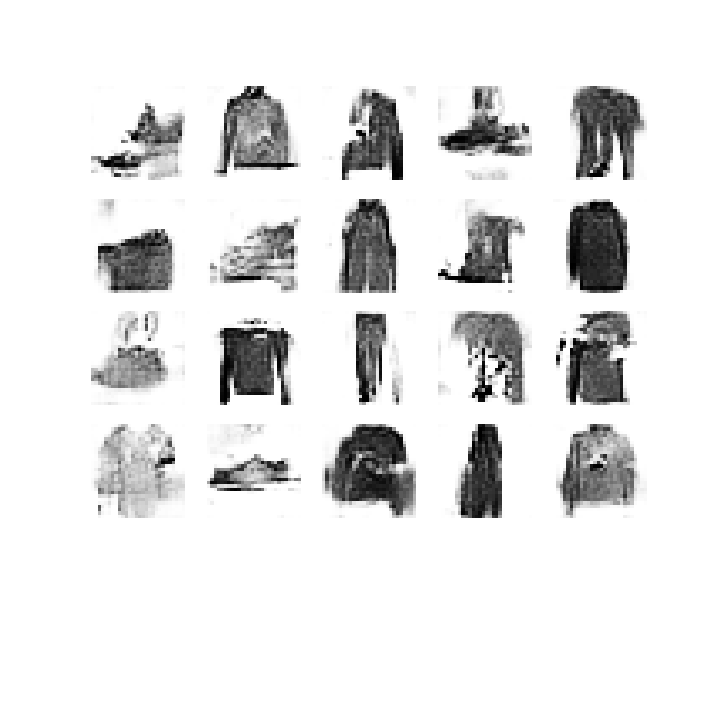

In [19]:
# Run this part to show the results as a GIF.
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())